git hub https://github.com/LeonelAvVi/InteligenciaII.git

carpeta de Dataset: https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -av /content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores /content/dataImg


'/content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores' -> '/content/dataImg'


In [ ]:
import os
path ='/content/dataImg/'
directorio = os.listdir(path)
directorio

['tagetes', 'Hibisco', 'FlorRita', 'claveles', 'Girasoles', 'lirio']

In [ ]:
labels_def = {'tagetes':0, 'Hibisco':1, 'Girasoles':2,'FlorRita':3,'claveles':4, 'lirio':5}
labels_def

{'FlorRita': 3,
 'Girasoles': 2,
 'Hibisco': 1,
 'claveles': 4,
 'lirio': 5,
 'tagetes': 0}

In [ ]:
import numpy as np
images =[]
labels = []
for d in directorio:
   imagenes = os.listdir(path + d)
   for i in imagenes:
       imgPath2 = path + d + '/' + i
       images.append(imgPath2)
       labels.append(labels_def[d])


In [ ]:
X_train = images
labels_train = labels


In [ ]:
def getName(label):
  for key in labels_def:
      if labels_def[key] == label:
        return(key)

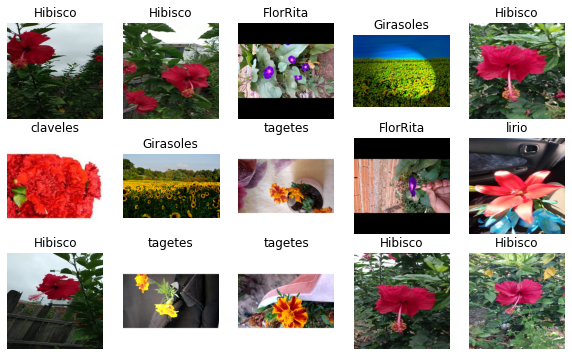

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(X_train)-1)
    img = io.imread(X_train[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getName(labels_train[ix]))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(X_train, labels_train, test_size=0.07, stratify=labels_train)

len(train_imgs), len(test_imgs)

(6298, 475)

Creacion de la clase Dataset


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    # self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img1 = Image.open(self.X[ix])
    new_img = img1.resize((92,92))
    #images.append(np.array(new_img)/255)
    return torch.from_numpy((np.array(new_img))/255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
Xtrain = dataset['train']
XText = dataset['test']
Xtrain

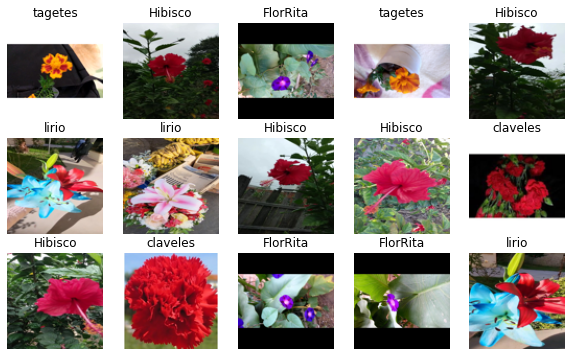

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getName(lab))
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 92, 92])

implementacion en pytorch


In [ ]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3)

output = conv(imgs)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([64, 10, 90, 90])

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=6):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*23*23, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [ ]:
model = CNN()

output = model(torch.randn(64, 3, 92, 92))

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
fit(model, dataloader)

loss 1.79173 acc 0.04688:   1%|          | 1/99 [00:16<27:32, 16.86s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 3.30782 acc 0.22656:   2%|▏         | 2/99 [00:32<26:22, 16.31s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.87698 acc 0.27083:   3%|▎         | 3/99 [00:47<25:02, 15.65s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.65702 acc 0.30859:   4%|▍         | 4/99 [01:05<25:58, 16.41s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.43772 acc 0.34063:   5%|▌         | 5/99 [01:21<25:53, 16.53s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.26725 acc 0.34375:   6%|▌         | 6/99 [01:37<25:02, 16.16s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.12832 acc 0.39062:   7%|▋         | 7/99 [01:54<25:01, 16.32s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 2.01525 acc 0.42773:   8%|▊         | 8/99 [02:09<24:20, 16.05s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.92991 acc 0.45139:   9%|▉         | 9/99 [02:24<23:20, 15.57s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.82198 acc 0.48594:  10%|█         | 10/99 [02:39<23:10, 15.62s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.72268 acc 0.51420:  11%|█         | 11/99 [02:56<23:31, 16.04s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.62907 acc 0.54036:  12%|█▏        | 12/99 [03:14<23:47, 16.41s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.54426 acc 0.56010:  13%|█▎        | 13/99 [03:31<24:11, 16.88s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.46474 acc 0.58147:  14%|█▍        | 14/99 [03:47<23:19, 16.46s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.39258 acc 0.60417:  15%|█▌        | 15/99 [04:03<22:51, 16.33s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.32380 acc 0.62402:  16%|█▌        | 16/99 [04:18<22:08, 16.01s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.25946 acc 0.64246:  17%|█▋        | 17/99 [04:34<21:53, 16.02s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.20380 acc 0.65625:  18%|█▊        | 18/99 [04:51<22:05, 16.37s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.16740 acc 0.66612:  19%|█▉        | 19/99 [05:06<21:14, 15.93s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.11871 acc 0.67891:  20%|██        | 20/99 [05:22<20:44, 15.75s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.08774 acc 0.68452:  21%|██        | 21/99 [05:37<20:21, 15.66s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.04666 acc 0.69602:  22%|██▏       | 22/99 [05:54<20:32, 16.01s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 1.01535 acc 0.70380:  23%|██▎       | 23/99 [06:10<20:06, 15.87s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.98069 acc 0.71289:  24%|██▍       | 24/99 [06:27<20:16, 16.21s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.95334 acc 0.72188:  25%|██▌       | 25/99 [06:43<20:01, 16.24s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.92649 acc 0.72957:  26%|██▋       | 26/99 [06:59<19:40, 16.16s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.89667 acc 0.73785:  27%|██▋       | 27/99 [07:14<19:03, 15.88s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.87163 acc 0.74498:  28%|██▊       | 28/99 [07:30<18:51, 15.94s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.84540 acc 0.75216:  29%|██▉       | 29/99 [07:46<18:39, 15.99s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.82329 acc 0.75833:  30%|███       | 30/99 [08:01<18:03, 15.71s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.80708 acc 0.76361:  31%|███▏      | 31/99 [08:18<18:05, 15.96s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.78519 acc 0.77051:  32%|███▏      | 32/99 [08:34<17:55, 16.05s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.77057 acc 0.77462:  33%|███▎      | 33/99 [08:49<17:12, 15.65s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.75235 acc 0.77987:  34%|███▍      | 34/99 [09:05<17:02, 15.73s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.73526 acc 0.78482:  35%|███▌      | 35/99 [09:20<16:36, 15.58s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.71733 acc 0.79080:  36%|███▋      | 36/99 [09:34<15:59, 15.22s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.70337 acc 0.79519:  37%|███▋      | 37/99 [09:49<15:41, 15.19s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.68924 acc 0.79975:  38%|███▊      | 38/99 [10:06<15:50, 15.58s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.67321 acc 0.80409:  39%|███▉      | 39/99 [10:21<15:30, 15.51s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.65919 acc 0.80742:  40%|████      | 40/99 [10:37<15:23, 15.65s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.64452 acc 0.81136:  41%|████▏     | 41/99 [10:53<15:11, 15.72s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.63008 acc 0.81548:  42%|████▏     | 42/99 [11:08<14:39, 15.42s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.61713 acc 0.81868:  43%|████▎     | 43/99 [11:23<14:15, 15.28s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.60561 acc 0.82209:  44%|████▍     | 44/99 [11:38<13:50, 15.10s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.59465 acc 0.82535:  45%|████▌     | 45/99 [11:53<13:44, 15.27s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.58419 acc 0.82812:  46%|████▋     | 46/99 [12:09<13:32, 15.33s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.57226 acc 0.83178:  47%|████▋     | 47/99 [12:23<12:54, 14.90s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.56355 acc 0.83366:  48%|████▊     | 48/99 [12:40<13:11, 15.52s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.55809 acc 0.83450:  49%|████▉     | 49/99 [12:58<13:32, 16.26s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.54903 acc 0.83688:  51%|█████     | 50/99 [13:11<12:39, 15.50s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.54021 acc 0.83946:  52%|█████▏    | 51/99 [13:29<13:03, 16.31s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.53107 acc 0.84225:  53%|█████▎    | 52/99 [13:44<12:22, 15.80s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.52272 acc 0.84493:  54%|█████▎    | 53/99 [14:00<12:08, 15.83s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.51455 acc 0.84722:  55%|█████▍    | 54/99 [14:16<11:54, 15.87s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.50563 acc 0.85000:  56%|█████▌    | 55/99 [14:33<11:50, 16.14s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.49816 acc 0.85240:  57%|█████▋    | 56/99 [14:48<11:29, 16.04s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.49052 acc 0.85444:  58%|█████▊    | 57/99 [15:03<10:52, 15.53s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.48437 acc 0.85641:  59%|█████▊    | 58/99 [15:18<10:26, 15.28s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.47751 acc 0.85858:  60%|█████▉    | 59/99 [15:33<10:15, 15.38s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.46986 acc 0.86094:  61%|██████    | 60/99 [15:49<10:06, 15.54s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.46242 acc 0.86322:  62%|██████▏   | 61/99 [16:02<09:23, 14.84s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.45855 acc 0.86492:  63%|██████▎   | 62/99 [16:18<09:21, 15.17s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.45193 acc 0.86682:  64%|██████▎   | 63/99 [16:34<09:11, 15.33s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.44628 acc 0.86865:  65%|██████▍   | 64/99 [16:48<08:39, 14.83s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.44091 acc 0.86995:  66%|██████▌   | 65/99 [17:04<08:41, 15.35s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.43446 acc 0.87192:  67%|██████▋   | 66/99 [17:21<08:39, 15.73s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.42854 acc 0.87383:  68%|██████▊   | 67/99 [17:36<08:20, 15.63s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.42252 acc 0.87569:  69%|██████▊   | 68/99 [17:53<08:12, 15.88s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.41654 acc 0.87749:  70%|██████▉   | 69/99 [18:11<08:15, 16.53s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.41102 acc 0.87924:  71%|███████   | 70/99 [18:25<07:42, 15.94s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.40572 acc 0.88072:  72%|███████▏  | 71/99 [18:40<07:16, 15.60s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.40218 acc 0.88216:  73%|███████▎  | 72/99 [18:57<07:09, 15.91s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.39785 acc 0.88356:  74%|███████▎  | 73/99 [19:13<06:59, 16.12s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.39281 acc 0.88492:  75%|███████▍  | 74/99 [19:28<06:29, 15.56s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.38779 acc 0.88646:  76%|███████▌  | 75/99 [19:43<06:11, 15.49s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.38342 acc 0.88754:  77%|███████▋  | 76/99 [20:00<06:08, 16.03s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.37873 acc 0.88900:  78%|███████▊  | 77/99 [20:15<05:44, 15.66s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.37415 acc 0.89042:  79%|███████▉  | 78/99 [20:29<05:21, 15.31s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.36971 acc 0.89181:  80%|███████▉  | 79/99 [20:48<05:27, 16.36s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.36522 acc 0.89316:  81%|████████  | 80/99 [21:03<04:59, 15.78s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.36192 acc 0.89429:  82%|████████▏ | 81/99 [21:16<04:28, 14.93s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.35965 acc 0.89520:  83%|████████▎ | 82/99 [21:31<04:14, 14.94s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.35564 acc 0.89627:  84%|████████▍ | 83/99 [21:45<03:57, 14.81s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.35164 acc 0.89751:  85%|████████▍ | 84/99 [22:01<03:46, 15.10s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.34774 acc 0.89871:  86%|████████▌ | 85/99 [22:14<03:21, 14.42s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.34511 acc 0.89953:  87%|████████▋ | 86/99 [22:30<03:14, 14.94s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.34335 acc 0.89978:  88%|████████▊ | 87/99 [22:45<02:58, 14.89s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.33965 acc 0.90092:  89%|████████▉ | 88/99 [23:01<02:47, 15.19s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.33670 acc 0.90169:  90%|████████▉ | 89/99 [23:17<02:36, 15.63s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.33343 acc 0.90260:  91%|█████████ | 90/99 [23:31<02:16, 15.21s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.33023 acc 0.90350:  92%|█████████▏| 91/99 [23:47<02:02, 15.36s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.32691 acc 0.90455:  93%|█████████▎| 92/99 [24:01<01:45, 15.04s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.32366 acc 0.90558:  94%|█████████▍| 93/99 [24:19<01:34, 15.79s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.32062 acc 0.90658:  95%|█████████▍| 94/99 [24:35<01:20, 16.01s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.31749 acc 0.90740:  96%|█████████▌| 95/99 [24:53<01:05, 16.36s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.31454 acc 0.90820:  97%|█████████▋| 96/99 [25:08<00:47, 16.00s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.31162 acc 0.90899:  98%|█████████▊| 97/99 [25:26<00:33, 16.57s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.30858 acc 0.90992:  99%|█████████▉| 98/99 [25:41<00:16, 16.07s/it]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.30579 acc 0.91083: 100%|██████████| 99/99 [25:46<00:00, 15.62s/it]


Dimensiones:
Entrada:  torch.Size([26, 3, 92, 92])
conv1:  torch.Size([26, 64, 46, 46])
conv2:  torch.Size([26, 128, 23, 23])
pre fc:  torch.Size([26, 67712])
Salida:  torch.Size([26, 6])


val_loss 0.04571 val_acc 0.98828:  50%|█████     | 1/2 [01:03<01:03, 63.73s/it]

Dimensiones:
Entrada:  torch.Size([256, 3, 92, 92])
conv1:  torch.Size([256, 64, 46, 46])
conv2:  torch.Size([256, 128, 23, 23])
pre fc:  torch.Size([256, 67712])
Salida:  torch.Size([256, 6])


val_loss 0.03158 val_acc 0.98957: 100%|██████████| 2/2 [01:59<00:00, 59.88s/it]


Dimensiones:
Entrada:  torch.Size([219, 3, 92, 92])
conv1:  torch.Size([219, 64, 46, 46])
conv2:  torch.Size([219, 128, 23, 23])
pre fc:  torch.Size([219, 67712])
Salida:  torch.Size([219, 6])
Epoch 1/5 loss 0.30579 val_loss 0.03158 acc 0.91083 val_acc 0.98957


loss 0.01899 acc 1.00000:   1%|          | 1/99 [00:00<01:02,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.04993 acc 0.98438:   2%|▏         | 2/99 [00:01<01:02,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03634 acc 0.98958:   3%|▎         | 3/99 [00:01<01:02,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03028 acc 0.99219:   4%|▍         | 4/99 [00:02<01:01,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02678 acc 0.99375:   5%|▌         | 5/99 [00:03<01:00,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02501 acc 0.99479:   6%|▌         | 6/99 [00:03<01:00,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02428 acc 0.99554:   7%|▋         | 7/99 [00:04<00:59,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02445 acc 0.99609:   8%|▊         | 8/99 [00:05<00:59,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02238 acc 0.99653:   9%|▉         | 9/99 [00:05<00:58,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03011 acc 0.99375:  10%|█         | 10/99 [00:06<00:57,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02766 acc 0.99432:  11%|█         | 11/99 [00:07<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02617 acc 0.99479:  12%|█▏        | 12/99 [00:07<00:55,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.02518 acc 0.99519:  13%|█▎        | 13/99 [00:08<00:55,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03033 acc 0.99442:  14%|█▍        | 14/99 [00:09<00:55,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03520 acc 0.99375:  15%|█▌        | 15/99 [00:09<00:54,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03444 acc 0.99316:  16%|█▌        | 16/99 [00:10<00:53,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03624 acc 0.99173:  17%|█▋        | 17/99 [00:10<00:52,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03721 acc 0.99132:  18%|█▊        | 18/99 [00:11<00:52,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03799 acc 0.99095:  19%|█▉        | 19/99 [00:12<00:52,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03674 acc 0.99141:  20%|██        | 20/99 [00:12<00:51,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.04053 acc 0.99107:  21%|██        | 21/99 [00:13<00:49,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03955 acc 0.99148:  22%|██▏       | 22/99 [00:14<00:48,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03828 acc 0.99185:  23%|██▎       | 23/99 [00:14<00:48,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03845 acc 0.99154:  24%|██▍       | 24/99 [00:15<00:47,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03854 acc 0.99187:  25%|██▌       | 25/99 [00:16<00:46,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03892 acc 0.99159:  26%|██▋       | 26/99 [00:16<00:46,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03795 acc 0.99190:  27%|██▋       | 27/99 [00:17<00:45,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03678 acc 0.99219:  28%|██▊       | 28/99 [00:18<00:45,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03581 acc 0.99246:  29%|██▉       | 29/99 [00:18<00:44,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03474 acc 0.99271:  30%|███       | 30/99 [00:19<00:44,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03685 acc 0.99143:  31%|███▏      | 31/99 [00:19<00:43,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03669 acc 0.99072:  32%|███▏      | 32/99 [00:20<00:42,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03618 acc 0.99053:  33%|███▎      | 33/99 [00:21<00:42,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03566 acc 0.99081:  34%|███▍      | 34/99 [00:21<00:41,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03543 acc 0.99062:  35%|███▌      | 35/99 [00:22<00:41,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03527 acc 0.99089:  36%|███▋      | 36/99 [00:23<00:39,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03476 acc 0.99113:  37%|███▋      | 37/99 [00:23<00:39,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03477 acc 0.99137:  38%|███▊      | 38/99 [00:24<00:38,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03426 acc 0.99159:  39%|███▉      | 39/99 [00:25<00:38,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03419 acc 0.99141:  40%|████      | 40/99 [00:25<00:38,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03579 acc 0.99085:  41%|████▏     | 41/99 [00:26<00:37,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03592 acc 0.99033:  42%|████▏     | 42/99 [00:26<00:36,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03538 acc 0.99055:  43%|████▎     | 43/99 [00:27<00:36,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03487 acc 0.99077:  44%|████▍     | 44/99 [00:28<00:35,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03422 acc 0.99097:  45%|████▌     | 45/99 [00:28<00:34,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03364 acc 0.99117:  46%|████▋     | 46/99 [00:29<00:34,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03375 acc 0.99102:  47%|████▋     | 47/99 [00:30<00:33,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03352 acc 0.99121:  48%|████▊     | 48/99 [00:30<00:33,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03325 acc 0.99139:  49%|████▉     | 49/99 [00:31<00:32,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03268 acc 0.99156:  51%|█████     | 50/99 [00:32<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03381 acc 0.99112:  52%|█████▏    | 51/99 [00:32<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03397 acc 0.99099:  53%|█████▎    | 52/99 [00:33<00:30,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03349 acc 0.99116:  54%|█████▎    | 53/99 [00:34<00:30,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03340 acc 0.99132:  55%|█████▍    | 54/99 [00:34<00:28,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03293 acc 0.99148:  56%|█████▌    | 55/99 [00:35<00:28,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03405 acc 0.99107:  57%|█████▋    | 56/99 [00:36<00:27,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03361 acc 0.99123:  58%|█████▊    | 57/99 [00:36<00:26,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03312 acc 0.99138:  59%|█████▊    | 58/99 [00:37<00:26,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03305 acc 0.99126:  60%|█████▉    | 59/99 [00:37<00:25,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03262 acc 0.99141:  61%|██████    | 60/99 [00:38<00:25,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03220 acc 0.99155:  62%|██████▏   | 61/99 [00:39<00:24,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03192 acc 0.99168:  63%|██████▎   | 62/99 [00:39<00:23,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03178 acc 0.99182:  64%|██████▎   | 63/99 [00:40<00:23,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03297 acc 0.99170:  65%|██████▍   | 64/99 [00:41<00:22,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03273 acc 0.99183:  66%|██████▌   | 65/99 [00:41<00:22,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03416 acc 0.99171:  67%|██████▋   | 66/99 [00:42<00:21,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03400 acc 0.99160:  68%|██████▊   | 67/99 [00:43<00:21,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03490 acc 0.99150:  69%|██████▊   | 68/99 [00:43<00:20,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03441 acc 0.99162:  70%|██████▉   | 69/99 [00:44<00:19,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03419 acc 0.99152:  71%|███████   | 70/99 [00:45<00:19,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03373 acc 0.99164:  72%|███████▏  | 71/99 [00:45<00:18,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03416 acc 0.99154:  73%|███████▎  | 72/99 [00:46<00:18,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03375 acc 0.99165:  74%|███████▎  | 73/99 [00:47<00:17,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03337 acc 0.99177:  75%|███████▍  | 74/99 [00:47<00:17,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03296 acc 0.99187:  76%|███████▌  | 75/99 [00:48<00:16,  1.45it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03325 acc 0.99178:  77%|███████▋  | 76/99 [00:49<00:15,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03385 acc 0.99168:  78%|███████▊  | 77/99 [00:49<00:14,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03405 acc 0.99159:  79%|███████▉  | 78/99 [00:50<00:13,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03414 acc 0.99150:  80%|███████▉  | 79/99 [00:51<00:12,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03432 acc 0.99141:  81%|████████  | 80/99 [00:51<00:12,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03467 acc 0.99132:  82%|████████▏ | 81/99 [00:52<00:11,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03449 acc 0.99143:  83%|████████▎ | 82/99 [00:53<00:11,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03431 acc 0.99153:  84%|████████▍ | 83/99 [00:53<00:10,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03396 acc 0.99163:  85%|████████▍ | 84/99 [00:54<00:09,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03374 acc 0.99173:  86%|████████▌ | 85/99 [00:55<00:09,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03349 acc 0.99182:  87%|████████▋ | 86/99 [00:55<00:08,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03351 acc 0.99174:  88%|████████▊ | 87/99 [00:56<00:07,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03348 acc 0.99183:  89%|████████▉ | 88/99 [00:57<00:07,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03331 acc 0.99192:  90%|████████▉ | 89/99 [00:57<00:06,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03302 acc 0.99201:  91%|█████████ | 90/99 [00:58<00:05,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03306 acc 0.99193:  92%|█████████▏| 91/99 [00:59<00:05,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03273 acc 0.99202:  93%|█████████▎| 92/99 [00:59<00:04,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03246 acc 0.99210:  94%|█████████▍| 93/99 [01:00<00:03,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03249 acc 0.99202:  95%|█████████▍| 94/99 [01:00<00:03,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03284 acc 0.99194:  96%|█████████▌| 95/99 [01:01<00:02,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03275 acc 0.99186:  97%|█████████▋| 96/99 [01:02<00:01,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03312 acc 0.99178:  98%|█████████▊| 97/99 [01:02<00:01,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03297 acc 0.99187:  99%|█████████▉| 98/99 [01:03<00:00,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.03264 acc 0.99195: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Dimensiones:
Entrada:  torch.Size([26, 3, 92, 92])
conv1:  torch.Size([26, 64, 46, 46])
conv2:  torch.Size([26, 128, 23, 23])
pre fc:  torch.Size([26, 67712])
Salida:  torch.Size([26, 6])


val_loss 0.00585 val_acc 1.00000:  50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Dimensiones:
Entrada:  torch.Size([256, 3, 92, 92])
conv1:  torch.Size([256, 64, 46, 46])
conv2:  torch.Size([256, 128, 23, 23])
pre fc:  torch.Size([256, 67712])
Salida:  torch.Size([256, 6])


val_loss 0.00464 val_acc 1.00000: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Dimensiones:
Entrada:  torch.Size([219, 3, 92, 92])
conv1:  torch.Size([219, 64, 46, 46])
conv2:  torch.Size([219, 128, 23, 23])
pre fc:  torch.Size([219, 67712])
Salida:  torch.Size([219, 6])
Epoch 2/5 loss 0.03264 val_loss 0.00464 acc 0.99195 val_acc 1.00000


loss 0.00789 acc 1.00000:   1%|          | 1/99 [00:00<01:02,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01486 acc 0.99219:   2%|▏         | 2/99 [00:01<00:59,  1.63it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01061 acc 0.99479:   3%|▎         | 3/99 [00:01<00:59,  1.62it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01195 acc 0.99609:   4%|▍         | 4/99 [00:02<00:58,  1.61it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01323 acc 0.99687:   5%|▌         | 5/99 [00:03<00:58,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01248 acc 0.99740:   6%|▌         | 6/99 [00:03<00:59,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01206 acc 0.99777:   7%|▋         | 7/99 [00:04<00:59,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01482 acc 0.99609:   8%|▊         | 8/99 [00:05<00:58,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01406 acc 0.99653:   9%|▉         | 9/99 [00:05<00:58,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01365 acc 0.99687:  10%|█         | 10/99 [00:06<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01414 acc 0.99716:  11%|█         | 11/99 [00:07<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01314 acc 0.99740:  12%|█▏        | 12/99 [00:07<00:56,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01511 acc 0.99639:  13%|█▎        | 13/99 [00:08<00:55,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01465 acc 0.99665:  14%|█▍        | 14/99 [00:08<00:54,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01402 acc 0.99687:  15%|█▌        | 15/99 [00:09<00:54,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01323 acc 0.99707:  16%|█▌        | 16/99 [00:10<00:53,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01427 acc 0.99540:  17%|█▋        | 17/99 [00:10<00:53,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01357 acc 0.99566:  18%|█▊        | 18/99 [00:11<00:53,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01327 acc 0.99589:  19%|█▉        | 19/99 [00:12<00:52,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01495 acc 0.99531:  20%|██        | 20/99 [00:12<00:51,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01426 acc 0.99554:  21%|██        | 21/99 [00:13<00:50,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01400 acc 0.99574:  22%|██▏       | 22/99 [00:14<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01370 acc 0.99592:  23%|██▎       | 23/99 [00:14<00:48,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01369 acc 0.99609:  24%|██▍       | 24/99 [00:15<00:47,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01336 acc 0.99625:  25%|██▌       | 25/99 [00:16<00:46,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01293 acc 0.99639:  26%|██▋       | 26/99 [00:16<00:45,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01315 acc 0.99595:  27%|██▋       | 27/99 [00:17<00:46,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01280 acc 0.99609:  28%|██▊       | 28/99 [00:18<00:45,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01285 acc 0.99623:  29%|██▉       | 29/99 [00:18<00:45,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01266 acc 0.99635:  30%|███       | 30/99 [00:19<00:44,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01238 acc 0.99647:  31%|███▏      | 31/99 [00:19<00:44,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01256 acc 0.99609:  32%|███▏      | 32/99 [00:20<00:42,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01221 acc 0.99621:  33%|███▎      | 33/99 [00:21<00:42,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01283 acc 0.99586:  34%|███▍      | 34/99 [00:21<00:41,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01256 acc 0.99598:  35%|███▌      | 35/99 [00:22<00:41,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01238 acc 0.99609:  36%|███▋      | 36/99 [00:23<00:40,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01265 acc 0.99578:  37%|███▋      | 37/99 [00:23<00:39,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01307 acc 0.99589:  38%|███▊      | 38/99 [00:24<00:39,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01283 acc 0.99599:  39%|███▉      | 39/99 [00:25<00:39,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01260 acc 0.99609:  40%|████      | 40/99 [00:25<00:39,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01232 acc 0.99619:  41%|████▏     | 41/99 [00:26<00:38,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01454 acc 0.99591:  42%|████▏     | 42/99 [00:27<00:37,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01423 acc 0.99600:  43%|████▎     | 43/99 [00:27<00:36,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01476 acc 0.99574:  44%|████▍     | 44/99 [00:28<00:35,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01450 acc 0.99583:  45%|████▌     | 45/99 [00:29<00:34,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01571 acc 0.99524:  46%|████▋     | 46/99 [00:29<00:33,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01542 acc 0.99535:  47%|████▋     | 47/99 [00:30<00:33,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01512 acc 0.99544:  48%|████▊     | 48/99 [00:30<00:32,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01487 acc 0.99554:  49%|████▉     | 49/99 [00:31<00:31,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01465 acc 0.99562:  51%|█████     | 50/99 [00:32<00:31,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01445 acc 0.99571:  52%|█████▏    | 51/99 [00:32<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01659 acc 0.99549:  53%|█████▎    | 52/99 [00:33<00:30,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01639 acc 0.99558:  54%|█████▎    | 53/99 [00:34<00:29,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01621 acc 0.99566:  55%|█████▍    | 54/99 [00:34<00:29,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01595 acc 0.99574:  56%|█████▌    | 55/99 [00:35<00:28,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01577 acc 0.99581:  57%|█████▋    | 56/99 [00:36<00:28,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01552 acc 0.99589:  58%|█████▊    | 57/99 [00:36<00:27,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01540 acc 0.99596:  59%|█████▊    | 58/99 [00:37<00:26,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01519 acc 0.99603:  60%|█████▉    | 59/99 [00:38<00:25,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01503 acc 0.99609:  61%|██████    | 60/99 [00:38<00:25,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01482 acc 0.99616:  62%|██████▏   | 61/99 [00:39<00:24,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01506 acc 0.99572:  63%|██████▎   | 62/99 [00:39<00:23,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01488 acc 0.99578:  64%|██████▎   | 63/99 [00:40<00:23,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01467 acc 0.99585:  65%|██████▍   | 64/99 [00:41<00:22,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01449 acc 0.99591:  66%|██████▌   | 65/99 [00:41<00:22,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01497 acc 0.99574:  67%|██████▋   | 66/99 [00:42<00:21,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01497 acc 0.99580:  68%|██████▊   | 67/99 [00:43<00:20,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01482 acc 0.99586:  69%|██████▊   | 68/99 [00:43<00:20,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01471 acc 0.99592:  70%|██████▉   | 69/99 [00:44<00:19,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01460 acc 0.99598:  71%|███████   | 70/99 [00:45<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01444 acc 0.99604:  72%|███████▏  | 71/99 [00:45<00:18,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01442 acc 0.99588:  73%|███████▎  | 72/99 [00:46<00:17,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01517 acc 0.99572:  74%|███████▎  | 73/99 [00:47<00:16,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01505 acc 0.99578:  75%|███████▍  | 74/99 [00:47<00:16,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01496 acc 0.99583:  76%|███████▌  | 75/99 [00:48<00:15,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01554 acc 0.99568:  77%|███████▋  | 76/99 [00:49<00:15,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01538 acc 0.99574:  78%|███████▊  | 77/99 [00:49<00:14,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01521 acc 0.99579:  79%|███████▉  | 78/99 [00:50<00:14,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01561 acc 0.99565:  80%|███████▉  | 79/99 [00:51<00:13,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01562 acc 0.99570:  81%|████████  | 80/99 [00:51<00:12,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01559 acc 0.99576:  82%|████████▏ | 81/99 [00:52<00:11,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01542 acc 0.99581:  83%|████████▎ | 82/99 [00:53<00:11,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01530 acc 0.99586:  84%|████████▍ | 83/99 [00:53<00:10,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01564 acc 0.99554:  85%|████████▍ | 84/99 [00:54<00:09,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01554 acc 0.99559:  86%|████████▌ | 85/99 [00:54<00:08,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01608 acc 0.99546:  87%|████████▋ | 86/99 [00:55<00:08,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01591 acc 0.99551:  88%|████████▊ | 87/99 [00:56<00:07,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01576 acc 0.99556:  89%|████████▉ | 88/99 [00:56<00:07,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01559 acc 0.99561:  90%|████████▉ | 89/99 [00:57<00:06,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01543 acc 0.99566:  91%|█████████ | 90/99 [00:58<00:05,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01527 acc 0.99571:  92%|█████████▏| 91/99 [00:58<00:05,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01518 acc 0.99575:  93%|█████████▎| 92/99 [00:59<00:04,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01507 acc 0.99580:  94%|█████████▍| 93/99 [01:00<00:03,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01501 acc 0.99584:  95%|█████████▍| 94/99 [01:00<00:03,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01487 acc 0.99589:  96%|█████████▌| 95/99 [01:01<00:02,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01481 acc 0.99593:  97%|█████████▋| 96/99 [01:02<00:01,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01470 acc 0.99597:  98%|█████████▊| 97/99 [01:02<00:01,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01457 acc 0.99601:  99%|█████████▉| 98/99 [01:03<00:00,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01443 acc 0.99605: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Dimensiones:
Entrada:  torch.Size([26, 3, 92, 92])
conv1:  torch.Size([26, 64, 46, 46])
conv2:  torch.Size([26, 128, 23, 23])
pre fc:  torch.Size([26, 67712])
Salida:  torch.Size([26, 6])


val_loss 0.00658 val_acc 0.99609:  50%|█████     | 1/2 [00:02<00:02,  2.43s/it]

Dimensiones:
Entrada:  torch.Size([256, 3, 92, 92])
conv1:  torch.Size([256, 64, 46, 46])
conv2:  torch.Size([256, 128, 23, 23])
pre fc:  torch.Size([256, 67712])
Salida:  torch.Size([256, 6])


val_loss 0.00477 val_acc 0.99805: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Dimensiones:
Entrada:  torch.Size([219, 3, 92, 92])
conv1:  torch.Size([219, 64, 46, 46])
conv2:  torch.Size([219, 128, 23, 23])
pre fc:  torch.Size([219, 67712])
Salida:  torch.Size([219, 6])
Epoch 3/5 loss 0.01443 val_loss 0.00477 acc 0.99605 val_acc 0.99805


loss 0.00221 acc 1.00000:   1%|          | 1/99 [00:00<01:01,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00298 acc 1.00000:   2%|▏         | 2/99 [00:01<01:00,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00343 acc 1.00000:   3%|▎         | 3/99 [00:01<01:01,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01264 acc 0.99609:   4%|▍         | 4/99 [00:02<01:00,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.01036 acc 0.99687:   5%|▌         | 5/99 [00:03<01:00,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00875 acc 0.99740:   6%|▌         | 6/99 [00:03<00:59,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00762 acc 0.99777:   7%|▋         | 7/99 [00:04<00:59,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00935 acc 0.99609:   8%|▊         | 8/99 [00:05<00:59,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00888 acc 0.99653:   9%|▉         | 9/99 [00:05<00:58,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00889 acc 0.99687:  10%|█         | 10/99 [00:06<00:58,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00924 acc 0.99716:  11%|█         | 11/99 [00:07<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00945 acc 0.99740:  12%|█▏        | 12/99 [00:07<00:57,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00882 acc 0.99760:  13%|█▎        | 13/99 [00:08<00:57,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00946 acc 0.99777:  14%|█▍        | 14/99 [00:09<00:55,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00889 acc 0.99792:  15%|█▌        | 15/99 [00:09<00:55,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00858 acc 0.99805:  16%|█▌        | 16/99 [00:10<00:53,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00814 acc 0.99816:  17%|█▋        | 17/99 [00:10<00:52,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00773 acc 0.99826:  18%|█▊        | 18/99 [00:11<00:52,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00738 acc 0.99836:  19%|█▉        | 19/99 [00:12<00:51,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00707 acc 0.99844:  20%|██        | 20/99 [00:12<00:50,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00683 acc 0.99851:  21%|██        | 21/99 [00:13<00:50,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00662 acc 0.99858:  22%|██▏       | 22/99 [00:14<00:49,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00671 acc 0.99864:  23%|██▎       | 23/99 [00:14<00:48,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00646 acc 0.99870:  24%|██▍       | 24/99 [00:15<00:48,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00628 acc 0.99875:  25%|██▌       | 25/99 [00:16<00:48,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00617 acc 0.99880:  26%|██▋       | 26/99 [00:16<00:47,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00834 acc 0.99826:  27%|██▋       | 27/99 [00:17<00:47,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00807 acc 0.99833:  28%|██▊       | 28/99 [00:18<00:45,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00789 acc 0.99838:  29%|██▉       | 29/99 [00:18<00:46,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00768 acc 0.99844:  30%|███       | 30/99 [00:19<00:44,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00753 acc 0.99849:  31%|███▏      | 31/99 [00:20<00:43,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00855 acc 0.99756:  32%|███▏      | 32/99 [00:20<00:43,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00836 acc 0.99763:  33%|███▎      | 33/99 [00:21<00:42,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00813 acc 0.99770:  34%|███▍      | 34/99 [00:22<00:42,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00808 acc 0.99777:  35%|███▌      | 35/99 [00:22<00:42,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00797 acc 0.99783:  36%|███▋      | 36/99 [00:23<00:40,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00789 acc 0.99789:  37%|███▋      | 37/99 [00:23<00:39,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00823 acc 0.99753:  38%|███▊      | 38/99 [00:24<00:39,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00804 acc 0.99760:  39%|███▉      | 39/99 [00:25<00:38,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00825 acc 0.99727:  40%|████      | 40/99 [00:25<00:37,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00810 acc 0.99733:  41%|████▏     | 41/99 [00:26<00:36,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00821 acc 0.99740:  42%|████▏     | 42/99 [00:27<00:35,  1.61it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00806 acc 0.99746:  43%|████▎     | 43/99 [00:27<00:35,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00802 acc 0.99751:  44%|████▍     | 44/99 [00:28<00:35,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00787 acc 0.99757:  45%|████▌     | 45/99 [00:29<00:34,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00771 acc 0.99762:  46%|████▋     | 46/99 [00:29<00:33,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00765 acc 0.99767:  47%|████▋     | 47/99 [00:30<00:32,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00753 acc 0.99772:  48%|████▊     | 48/99 [00:30<00:32,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00743 acc 0.99777:  49%|████▉     | 49/99 [00:31<00:32,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00738 acc 0.99781:  51%|█████     | 50/99 [00:32<00:31,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00734 acc 0.99786:  52%|█████▏    | 51/99 [00:32<00:31,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00723 acc 0.99790:  53%|█████▎    | 52/99 [00:33<00:29,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00731 acc 0.99764:  54%|█████▎    | 53/99 [00:34<00:29,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00756 acc 0.99740:  55%|█████▍    | 54/99 [00:34<00:28,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00745 acc 0.99744:  56%|█████▌    | 55/99 [00:35<00:28,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00732 acc 0.99749:  57%|█████▋    | 56/99 [00:36<00:27,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00841 acc 0.99726:  58%|█████▊    | 57/99 [00:36<00:26,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00845 acc 0.99731:  59%|█████▊    | 58/99 [00:37<00:26,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00834 acc 0.99735:  60%|█████▉    | 59/99 [00:38<00:25,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00823 acc 0.99740:  61%|██████    | 60/99 [00:38<00:25,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00811 acc 0.99744:  62%|██████▏   | 61/99 [00:39<00:24,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00811 acc 0.99748:  63%|██████▎   | 62/99 [00:40<00:24,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00802 acc 0.99752:  64%|██████▎   | 63/99 [00:40<00:23,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00790 acc 0.99756:  65%|██████▍   | 64/99 [00:41<00:22,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00779 acc 0.99760:  66%|██████▌   | 65/99 [00:41<00:22,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00768 acc 0.99763:  67%|██████▋   | 66/99 [00:42<00:21,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00757 acc 0.99767:  68%|██████▊   | 67/99 [00:43<00:21,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00746 acc 0.99770:  69%|██████▊   | 68/99 [00:43<00:20,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00736 acc 0.99774:  70%|██████▉   | 69/99 [00:44<00:19,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00726 acc 0.99777:  71%|███████   | 70/99 [00:45<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00716 acc 0.99780:  72%|███████▏  | 71/99 [00:45<00:18,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00709 acc 0.99783:  73%|███████▎  | 72/99 [00:46<00:18,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00708 acc 0.99786:  74%|███████▎  | 73/99 [00:47<00:17,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00701 acc 0.99789:  75%|███████▍  | 74/99 [00:47<00:16,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00701 acc 0.99792:  76%|███████▌  | 75/99 [00:48<00:15,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00693 acc 0.99794:  77%|███████▋  | 76/99 [00:49<00:14,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00704 acc 0.99777:  78%|███████▊  | 77/99 [00:49<00:14,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00696 acc 0.99780:  79%|███████▉  | 78/99 [00:50<00:13,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00688 acc 0.99782:  80%|███████▉  | 79/99 [00:51<00:12,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00682 acc 0.99785:  81%|████████  | 80/99 [00:51<00:12,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00691 acc 0.99788:  82%|████████▏ | 81/99 [00:52<00:11,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00683 acc 0.99790:  83%|████████▎ | 82/99 [00:52<00:10,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00678 acc 0.99793:  84%|████████▍ | 83/99 [00:53<00:10,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00671 acc 0.99795:  85%|████████▍ | 84/99 [00:54<00:09,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00666 acc 0.99798:  86%|████████▌ | 85/99 [00:54<00:08,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00660 acc 0.99800:  87%|████████▋ | 86/99 [00:55<00:08,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00666 acc 0.99802:  88%|████████▊ | 87/99 [00:56<00:07,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00663 acc 0.99805:  89%|████████▉ | 88/99 [00:56<00:06,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00656 acc 0.99807:  90%|████████▉ | 89/99 [00:57<00:06,  1.61it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00680 acc 0.99792:  91%|█████████ | 90/99 [00:57<00:05,  1.60it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00676 acc 0.99794:  92%|█████████▏| 91/99 [00:58<00:05,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00690 acc 0.99779:  93%|█████████▎| 92/99 [00:59<00:04,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00684 acc 0.99782:  94%|█████████▍| 93/99 [00:59<00:03,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00678 acc 0.99784:  95%|█████████▍| 94/99 [01:00<00:03,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00692 acc 0.99770:  96%|█████████▌| 95/99 [01:01<00:02,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00689 acc 0.99772:  97%|█████████▋| 96/99 [01:01<00:01,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00685 acc 0.99774:  98%|█████████▊| 97/99 [01:02<00:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00700 acc 0.99761:  99%|█████████▉| 98/99 [01:03<00:00,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00694 acc 0.99763: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Dimensiones:
Entrada:  torch.Size([26, 3, 92, 92])
conv1:  torch.Size([26, 64, 46, 46])
conv2:  torch.Size([26, 128, 23, 23])
pre fc:  torch.Size([26, 67712])
Salida:  torch.Size([26, 6])


val_loss 0.00348 val_acc 1.00000:  50%|█████     | 1/2 [00:02<00:02,  2.41s/it]

Dimensiones:
Entrada:  torch.Size([256, 3, 92, 92])
conv1:  torch.Size([256, 64, 46, 46])
conv2:  torch.Size([256, 128, 23, 23])
pre fc:  torch.Size([256, 67712])
Salida:  torch.Size([256, 6])


val_loss 0.00284 val_acc 1.00000: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Dimensiones:
Entrada:  torch.Size([219, 3, 92, 92])
conv1:  torch.Size([219, 64, 46, 46])
conv2:  torch.Size([219, 128, 23, 23])
pre fc:  torch.Size([219, 67712])
Salida:  torch.Size([219, 6])
Epoch 4/5 loss 0.00694 val_loss 0.00284 acc 0.99763 val_acc 1.00000


loss 0.00115 acc 1.00000:   1%|          | 1/99 [00:00<01:04,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00176 acc 1.00000:   2%|▏         | 2/99 [00:01<01:02,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00155 acc 1.00000:   3%|▎         | 3/99 [00:01<01:01,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00200 acc 1.00000:   4%|▍         | 4/99 [00:02<01:02,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00200 acc 1.00000:   5%|▌         | 5/99 [00:03<01:00,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00273 acc 1.00000:   6%|▌         | 6/99 [00:03<00:59,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00389 acc 1.00000:   7%|▋         | 7/99 [00:04<00:59,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00342 acc 1.00000:   8%|▊         | 8/99 [00:05<00:58,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00401 acc 1.00000:   9%|▉         | 9/99 [00:05<00:57,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00365 acc 1.00000:  10%|█         | 10/99 [00:06<00:58,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00346 acc 1.00000:  11%|█         | 11/99 [00:07<00:57,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00323 acc 1.00000:  12%|█▏        | 12/99 [00:07<00:56,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00302 acc 1.00000:  13%|█▎        | 13/99 [00:08<00:54,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00288 acc 1.00000:  14%|█▍        | 14/99 [00:09<00:55,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00296 acc 1.00000:  15%|█▌        | 15/99 [00:09<00:56,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00398 acc 0.99902:  16%|█▌        | 16/99 [00:10<00:55,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00377 acc 0.99908:  17%|█▋        | 17/99 [00:11<00:54,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00370 acc 0.99913:  18%|█▊        | 18/99 [00:11<00:52,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00355 acc 0.99918:  19%|█▉        | 19/99 [00:12<00:52,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00339 acc 0.99922:  20%|██        | 20/99 [00:13<00:52,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00339 acc 0.99926:  21%|██        | 21/99 [00:13<00:50,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00343 acc 0.99929:  22%|██▏       | 22/99 [00:14<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00347 acc 0.99932:  23%|██▎       | 23/99 [00:14<00:49,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00334 acc 0.99935:  24%|██▍       | 24/99 [00:15<00:47,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00385 acc 0.99875:  25%|██▌       | 25/99 [00:16<00:46,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00384 acc 0.99880:  26%|██▋       | 26/99 [00:16<00:45,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00374 acc 0.99884:  27%|██▋       | 27/99 [00:17<00:45,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00407 acc 0.99833:  28%|██▊       | 28/99 [00:18<00:45,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00411 acc 0.99838:  29%|██▉       | 29/99 [00:18<00:44,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00408 acc 0.99844:  30%|███       | 30/99 [00:19<00:43,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00399 acc 0.99849:  31%|███▏      | 31/99 [00:19<00:43,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00490 acc 0.99805:  32%|███▏      | 32/99 [00:20<00:42,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00491 acc 0.99811:  33%|███▎      | 33/99 [00:21<00:41,  1.59it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00487 acc 0.99816:  34%|███▍      | 34/99 [00:21<00:41,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00473 acc 0.99821:  35%|███▌      | 35/99 [00:22<00:40,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00462 acc 0.99826:  36%|███▋      | 36/99 [00:23<00:39,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00450 acc 0.99831:  37%|███▋      | 37/99 [00:23<00:40,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00445 acc 0.99836:  38%|███▊      | 38/99 [00:24<00:39,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00437 acc 0.99840:  39%|███▉      | 39/99 [00:25<00:39,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00446 acc 0.99844:  40%|████      | 40/99 [00:25<00:37,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00438 acc 0.99848:  41%|████▏     | 41/99 [00:26<00:36,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00430 acc 0.99851:  42%|████▏     | 42/99 [00:27<00:36,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00425 acc 0.99855:  43%|████▎     | 43/99 [00:27<00:35,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00461 acc 0.99822:  44%|████▍     | 44/99 [00:28<00:35,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00465 acc 0.99826:  45%|████▌     | 45/99 [00:29<00:35,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00457 acc 0.99830:  46%|████▋     | 46/99 [00:29<00:34,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00552 acc 0.99801:  47%|████▋     | 47/99 [00:30<00:33,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00547 acc 0.99805:  48%|████▊     | 48/99 [00:30<00:32,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00545 acc 0.99809:  49%|████▉     | 49/99 [00:31<00:32,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00569 acc 0.99813:  51%|█████     | 50/99 [00:32<00:31,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00565 acc 0.99816:  52%|█████▏    | 51/99 [00:32<00:30,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00635 acc 0.99790:  53%|█████▎    | 52/99 [00:33<00:30,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00625 acc 0.99794:  54%|█████▎    | 53/99 [00:34<00:29,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00616 acc 0.99797:  55%|█████▍    | 54/99 [00:34<00:29,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00605 acc 0.99801:  56%|█████▌    | 55/99 [00:35<00:28,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00598 acc 0.99805:  57%|█████▋    | 56/99 [00:36<00:27,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00588 acc 0.99808:  58%|█████▊    | 57/99 [00:36<00:26,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00731 acc 0.99784:  59%|█████▊    | 58/99 [00:37<00:26,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00722 acc 0.99788:  60%|█████▉    | 59/99 [00:38<00:26,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00764 acc 0.99766:  61%|██████    | 60/99 [00:38<00:25,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00757 acc 0.99769:  62%|██████▏   | 61/99 [00:39<00:24,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00751 acc 0.99773:  63%|██████▎   | 62/99 [00:40<00:24,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00741 acc 0.99777:  64%|██████▎   | 63/99 [00:40<00:24,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00742 acc 0.99780:  65%|██████▍   | 64/99 [00:41<00:23,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00735 acc 0.99784:  66%|██████▌   | 65/99 [00:41<00:22,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00735 acc 0.99787:  67%|██████▋   | 66/99 [00:42<00:21,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00727 acc 0.99790:  68%|██████▊   | 67/99 [00:43<00:20,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00718 acc 0.99793:  69%|██████▊   | 68/99 [00:43<00:20,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00712 acc 0.99796:  70%|██████▉   | 69/99 [00:44<00:19,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00740 acc 0.99777:  71%|███████   | 70/99 [00:45<00:18,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00784 acc 0.99758:  72%|███████▏  | 71/99 [00:45<00:17,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00783 acc 0.99761:  73%|███████▎  | 72/99 [00:46<00:17,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00774 acc 0.99765:  74%|███████▎  | 73/99 [00:47<00:16,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00815 acc 0.99747:  75%|███████▍  | 74/99 [00:47<00:16,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00807 acc 0.99750:  76%|███████▌  | 75/99 [00:48<00:15,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00798 acc 0.99753:  77%|███████▋  | 76/99 [00:49<00:14,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00792 acc 0.99756:  78%|███████▊  | 77/99 [00:49<00:14,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00856 acc 0.99740:  79%|███████▉  | 78/99 [00:50<00:13,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00850 acc 0.99743:  80%|███████▉  | 79/99 [00:50<00:12,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00840 acc 0.99746:  81%|████████  | 80/99 [00:51<00:12,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00831 acc 0.99749:  82%|████████▏ | 81/99 [00:52<00:11,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00822 acc 0.99752:  83%|████████▎ | 82/99 [00:52<00:11,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00813 acc 0.99755:  84%|████████▍ | 83/99 [00:53<00:10,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00922 acc 0.99740:  85%|████████▍ | 84/99 [00:54<00:09,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00951 acc 0.99724:  86%|████████▌ | 85/99 [00:54<00:09,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00941 acc 0.99727:  87%|████████▋ | 86/99 [00:55<00:08,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00940 acc 0.99731:  88%|████████▊ | 87/99 [00:56<00:07,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00944 acc 0.99734:  89%|████████▉ | 88/99 [00:56<00:07,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00946 acc 0.99737:  90%|████████▉ | 89/99 [00:57<00:06,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00957 acc 0.99722:  91%|█████████ | 90/99 [00:58<00:05,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00984 acc 0.99708:  92%|█████████▏| 91/99 [00:58<00:05,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00975 acc 0.99711:  93%|█████████▎| 92/99 [00:59<00:04,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00969 acc 0.99714:  94%|█████████▍| 93/99 [01:00<00:03,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00960 acc 0.99717:  95%|█████████▍| 94/99 [01:00<00:03,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00958 acc 0.99720:  96%|█████████▌| 95/99 [01:01<00:02,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00950 acc 0.99723:  97%|█████████▋| 96/99 [01:01<00:01,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00941 acc 0.99726:  98%|█████████▊| 97/99 [01:02<00:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00932 acc 0.99729:  99%|█████████▉| 98/99 [01:03<00:00,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([64, 3, 92, 92])
conv1:  torch.Size([64, 64, 46, 46])
conv2:  torch.Size([64, 128, 23, 23])
pre fc:  torch.Size([64, 67712])
Salida:  torch.Size([64, 6])


loss 0.00935 acc 0.99732: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Dimensiones:
Entrada:  torch.Size([26, 3, 92, 92])
conv1:  torch.Size([26, 64, 46, 46])
conv2:  torch.Size([26, 128, 23, 23])
pre fc:  torch.Size([26, 67712])
Salida:  torch.Size([26, 6])


val_loss 0.00693 val_acc 1.00000:  50%|█████     | 1/2 [00:02<00:02,  2.41s/it]

Dimensiones:
Entrada:  torch.Size([256, 3, 92, 92])
conv1:  torch.Size([256, 64, 46, 46])
conv2:  torch.Size([256, 128, 23, 23])
pre fc:  torch.Size([256, 67712])
Salida:  torch.Size([256, 6])


val_loss 0.00492 val_acc 1.00000: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

Dimensiones:
Entrada:  torch.Size([219, 3, 92, 92])
conv1:  torch.Size([219, 64, 46, 46])
conv2:  torch.Size([219, 128, 23, 23])
pre fc:  torch.Size([219, 67712])
Salida:  torch.Size([219, 6])
Epoch 5/5 loss 0.00935 val_loss 0.00492 acc 0.99732 val_acc 1.00000
